In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import PIL

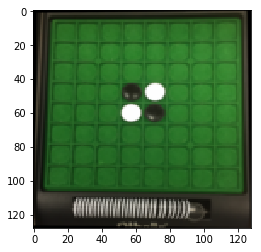

In [8]:
img = PIL.Image.open("Othello.png")
img = (np.array(img.getdata(), dtype="float32") / 256).reshape(128,128,4)[:,:,0:3].transpose((2, 0, 1))
img.shape

plt.imshow(img.transpose((1, 2, 0)))
plt.show()

In [24]:
"""
    X: -1 x 3 x 128 x 128
    Conv(50, 5) + Maxpool(4)
    -1 x 50 x 31 x 31
    Conv(4) + Maxpool(3)
    -1 x 4 x 9 x 9
    Reshape(324)
    -1 x 324
    
    Append(Y: -1 x 256)
    -1 x 512
    Connected(256)
    -1 x 256
    
    Reshape(4, 8, 8)
    -1 x 4 x 8 x 8
    Conv(50) + Upscale(4)
    -1 x 50 x 32 x 32
    Conv(3) + Upscale(4)
    -1 x 3 x 128 x 128
"""

class BOThello(nn.Module):
    def __init__(self):
        super(BOThello, self).__init__()
        
        self.conv_in_1 = nn.Conv2d(3, 50, 5)
        self.conv_in_2 = nn.Conv2d(50, 4, 5)
        
        self.conn = nn.Linear(324, 256)
        
        self.conv_out_1 = nn.Conv2d(4, 50, 6)
        self.conv_out_2 = nn.Conv2d(50, 3, 8)
    
    def forward(self, x):
        x = self.conv_in_1(x)
        x = F.relu(F.max_pool2d(x, (4, 4)))
        x = self.conv_in_2(x)
        x = F.relu(F.max_pool2d(x, (3, 3)))
        
        x = x.view(-1, 324)
        x = self.conn(x)
        x = F.relu(x)
        x = x.view(-1, 4, 8, 8)
        
        x = F.upsample(x, scale_factor=4)
        x = self.conv_out_1(x)
        x = F.upsample(x, scale_factor=5)
        x = self.conv_out_2(x)
        
        return x

bot = BOThello()


In [25]:
data = Variable(torch.from_numpy(img.reshape(1, *img.shape)))
res = bot(data)

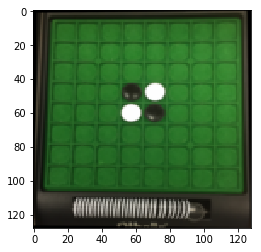

In [ ]:
plt.imshow(np.array(img).transpose((1, 2, 0)))
plt.show()
plt.imshow(np.array(res.data)[0].transpose((1, 2, 0)))
plt.show()


'torch.FloatTensor'